# Does performance in pre-all star season predict playoff ranking? 
- Supervised offline binary classification task with imbalanced data
- Performance measure: average precision (AUPRC)
- Data source: https://www.nba.com/stats/teams/traditional/?sort=W&dir=-1&Season=2021-22&SeasonType=Regular%20Season 
- By predicting the probability of winning the championship based on mid-season (defined as regular season pre all-star game) performance of the NBA teams performance in the regular season before the All-Star game, 
  - As fans, we can tell whether our favorite team has a high chance to win this year during the middle of the season
  - As coaching staff and team manager, we can tell if we need to make a change in our roster to increase our chances

In [1]:
!pip install nba_api

     ------------------------------------ 125.6/125.6 kB 670.5 kB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for nba_api: filename=nba_api-1.1.11-py3-none-any.whl size=251487 sha256=ab0c9c5024f45020bb184a5d518d196a4f88467ad964eff330903f9f7c3fd913
  Stored in directory: c:\users\willi\appdata\local\pip\cache\wheels\a4\cb\9e\94c3e6e4066a5930821218287bdb191a6bc31b0de8b0218dd1
Successfully built nba_api


In [2]:
import pandas as pd
from nba_api.stats.endpoints import leaguedashteamstats, leaguedashplayerstats
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)
import os
from tqdm import tqdm
import numpy as np
from zlib import crc32
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [20, 5]
import re
import copy

# Gather data with [nba api](https://github.com/swar/nba_api)
- stats adjusted per 100 posessions, instead of per game, to account for the different pace each team plays at
- [glossary](https://www.nba.com/stats/help/glossary/) for column names  
- extra data: [advanced team stats](https://www.nba.com/stats/teams/advanced/?sort=W&dir=-1) 



In [3]:
per_mode = 'Per100Possessions'

def get_team_table(measure_type, season, season_type, season_segment=""):
  # documentation: https://github.com/swar/nba_api/blob/master/docs/nba_api/stats/endpoints/leaguedashteamstats.md
  return leaguedashteamstats.LeagueDashTeamStats(
      per_mode_detailed=per_mode, 
      measure_type_detailed_defense=measure_type,
      season=season, 
      season_type_all_star=season_type,
      season_segment_nullable=season_segment).get_data_frames()[0]

def get_player_table(measure_type, season, season_type, season_segment=""):
  # documentation: https://github.com/swar/nba_api/blob/master/docs/nba_api/stats/endpoints/leaguedashplayerstats.md
  return leaguedashplayerstats.LeagueDashPlayerStats(
      per_mode_detailed=per_mode, 
      measure_type_detailed_defense=measure_type,
      season=season, 
      season_type_all_star=season_type,
      season_segment_nullable=season_segment).get_data_frames()[0]

In [17]:
season = '2006-07'
season_df = get_team_table("Base", season, "Regular Season", "Pre All-Star")
list_of_measures = ["Advanced", "Misc", "Four Factors", "Scoring", "Opponent", "Defense"]
for measure in list_of_measures:
  try:
    print(measure)
    print(get_team_table(measure, season, "Regular Season", "Pre All-Star").columns.values)
  except:
    print(f"error at {measure}")

Advanced
['TEAM_ID' 'TEAM_NAME' 'GP' 'W' 'L' 'W_PCT' 'MIN' 'E_OFF_RATING'
 'OFF_RATING' 'E_DEF_RATING' 'DEF_RATING' 'E_NET_RATING' 'NET_RATING'
 'AST_PCT' 'AST_TO' 'AST_RATIO' 'OREB_PCT' 'DREB_PCT' 'REB_PCT'
 'TM_TOV_PCT' 'EFG_PCT' 'TS_PCT' 'E_PACE' 'PACE' 'PACE_PER40' 'POSS' 'PIE'
 'GP_RANK' 'W_RANK' 'L_RANK' 'W_PCT_RANK' 'MIN_RANK' 'OFF_RATING_RANK'
 'DEF_RATING_RANK' 'NET_RATING_RANK' 'AST_PCT_RANK' 'AST_TO_RANK'
 'AST_RATIO_RANK' 'OREB_PCT_RANK' 'DREB_PCT_RANK' 'REB_PCT_RANK'
 'TM_TOV_PCT_RANK' 'EFG_PCT_RANK' 'TS_PCT_RANK' 'PACE_RANK' 'PIE_RANK'
 'CFID' 'CFPARAMS']
Misc
['TEAM_ID' 'TEAM_NAME' 'GP' 'W' 'L' 'W_PCT' 'MIN' 'PTS_OFF_TOV'
 'PTS_2ND_CHANCE' 'PTS_FB' 'PTS_PAINT' 'OPP_PTS_OFF_TOV'
 'OPP_PTS_2ND_CHANCE' 'OPP_PTS_FB' 'OPP_PTS_PAINT' 'GP_RANK' 'W_RANK'
 'L_RANK' 'W_PCT_RANK' 'MIN_RANK' 'PTS_OFF_TOV_RANK' 'PTS_2ND_CHANCE_RANK'
 'PTS_FB_RANK' 'PTS_PAINT_RANK' 'OPP_PTS_OFF_TOV_RANK'
 'OPP_PTS_2ND_CHANCE_RANK' 'OPP_PTS_FB_RANK' 'OPP_PTS_PAINT_RANK' 'CFID'
 'CFPARAMS']
Four Factors

In [5]:
playoff_df = get_team_table("Base", season, "Playoffs")

In [11]:
def season_vs_playoff(start_year, end_year):
  output = None
  season_list = [str(i) + '-' + str(i+1)[2:] for i in range(start_year, end_year)]
  with tqdm(total=len(season_list)) as pbar:
    for season in season_list:
       
      # df for team stats
      try:
        team_df = get_team_table("Base", season, "Regular Season", "Pre All-Star")
      except:
        print(f"error at Base {season} team")
      list_of_measures = ["Advanced", "Misc", "Four Factors", "Scoring", "Opponent", "Defense"]
      for measure in list_of_measures:
        try:
          result_df = get_team_table(measure, season, "Regular Season", "Pre All-Star")
          # print(f"{measure} success")
          team_df = team_df.merge(
            result_df[['TEAM_ID'] + result_df.columns.difference(team_df.columns).tolist()], # only keep the unique columns + TEAM_ID
            on = "TEAM_ID", how = "inner", suffixes = ("", "_y"))
        except: 
          print(f"error at {measure} {season} team")

      remaining_col = [x for x in team_df.columns if 
                      (re.search('_RANK$', x) is None) &   # remove columns ending in _RANK as we will clean our features later
                      (re.search('^E_\w+', x) is None)     # remove columns starting with E_ (unknown estimates provided by NBA)
                      ]
      try:
        team_df = team_df[remaining_col]
      except:
        print(f"error at team {season}")

      season_df = copy.deepcopy(team_df)

      try:

        playoff_df = get_team_table("Base", season, "Playoffs")
        
        # Final 4 teams = 1, else = 0
        playoff_df = playoff_df.sort_values(by=['W', 'GP'], ascending=False).head(4)
        playoff_df[['PLAYOFF_RANKING']] = 1

        playoff_df = playoff_df[['TEAM_ID', 'PLAYOFF_RANKING']] 

        season_vs_playoff = pd.merge(season_df, playoff_df, left_on='TEAM_ID', right_on='TEAM_ID', how = 'left')
        season_vs_playoff.fillna(0, inplace=True) # teams which are not in playoff will have 0 as PLAYOFF_RANKING
        season_vs_playoff['PLAYOFF_RANKING'] = season_vs_playoff['PLAYOFF_RANKING'].astype(int)
        season_vs_playoff['SEASON'] = season
        output = pd.concat([output,season_vs_playoff.sort_values(by='PLAYOFF_RANKING', ascending = False).reset_index(drop=True)], axis = 0)

      except Exception as e:
        print(f"error at {season}, {e}")

      pbar.update(1)
  
  return output

In [12]:
df = season_vs_playoff(start_year = 1996, end_year = 2022)
df

 38%|███▊      | 10/26 [01:37<02:42, 10.17s/it]

error at Scoring 2006-07 team


100%|██████████| 26/26 [04:00<00:00,  9.26s/it]


,TEAM_ID,TEAM_NAME,GP,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,CFID,CFPARAMS,AST_PCT,AST_RATIO,AST_TO,DEF_RATING,DREB_PCT,EFG_PCT,NET_RATING,OFF_RATING,OREB_PCT,PACE,PACE_PER40,PIE,POSS,REB_PCT,TM_TOV_PCT,TS_PCT,OPP_PTS_2ND_CHANCE,OPP_PTS_FB,OPP_PTS_OFF_TOV,OPP_PTS_PAINT,PTS_2ND_CHANCE,PTS_FB,PTS_OFF_TOV,PTS_PAINT,FTA_RATE,OPP_EFG_PCT,OPP_FTA_RATE,OPP_OREB_PCT,OPP_TOV_PCT,PCT_AST_2PM,PCT_AST_3PM,PCT_AST_FGM,PCT_FGA_2PT,PCT_FGA_3PT,PCT_PTS_2PT,PCT_PTS_2PT_MR,PCT_PTS_3PT,PCT_PTS_FB,PCT_PTS_FT,PCT_PTS_OFF_TOV,PCT_PTS_PAINT,PCT_UAST_2PM,PCT_UAST_3PM,PCT_UAST_FGM,OPP_AST,OPP_BLK,OPP_BLKA,OPP_DREB,OPP_FG3A,OPP_FG3M,OPP_FG3_PCT,OPP_FGA,OPP_FGM,OPP_FG_PCT,OPP_FTA,OPP_FTM,OPP_FT_PCT,OPP_OREB,OPP_PF,OPP_PFD,OPP_PTS,OPP_REB,OPP_STL,OPP_TOV,PLAYOFF_RANKING,SEASON
0,1610612741,Chicago Bulls,48,42,6,0.875,52.4,43.4,92.0,0.471,6.8,18.9,0.361,18.0,24.3,0.743,16.0,32.3,48.2,27.7,14.3,9.5,4.1,3.8,21.2,0.1,111.6,12.8,10,Chicago Bulls,0.640,19.0,1.94,98.7,0.671,0.508,12.9,111.6,0.362,91.56,76.30,0.592,4403,0.518,0.143,0.543,15.7,11.1,14.9,41.7,17.9,13.9,21.4,39.1,0.264,0.467,0.259,0.329,0.178,0.611,0.793,0.640,0.795,0.205,0.655,0.305,0.183,0.125,0.162,0.192,0.350,0.389,0.207,0.360,20.8,3.8,4.1,29.9,18.7,6.0,0.318,88.0,38.1,0.433,22.8,16.6,0.727,14.4,23.0,21.2,98.8,44.3,7.9,17.9,1,1996-97
1,1610612762,Utah Jazz,47,33,14,0.702,53.0,40.6,83.0,0.490,4.4,12.2,0.362,22.7,29.9,0.759,11.8,32.3,44.1,28.2,17.0,9.7,5.1,5.2,26.6,0.3,108.4,7.1,10,Utah Jazz,0.695,19.9,1.66,100.9,0.687,0.516,7.4,108.4,0.311,90.74,75.62,0.571,4305,0.508,0.170,0.563,14.0,9.0,17.7,37.1,12.8,14.3,20.4,45.9,0.360,0.474,0.381,0.313,0.179,0.688,0.747,0.695,0.853,0.147,0.668,0.244,0.122,0.132,0.209,0.188,0.424,0.312,0.253,0.305,21.2,5.2,5.1,29.5,20.1,6.8,0.337,82.3,35.6,0.432,31.4,23.3,0.744,12.8,26.3,26.6,101.3,42.3,8.4,17.9,1,1996-97
2,1610612745,Houston Rockets,48,32,16,0.667,51.8,38.7,83.6,0.462,8.3,23.2,0.359,20.3,27.4,0.740,12.4,33.3,45.7,25.8,18.7,9.2,4.5,5.1,21.2,0.2,105.9,3.6,10,Houston Rockets,0.668,18.3,1.38,102.3,0.687,0.512,3.7,105.9,0.328,92.75,77.30,0.531,4509,0.515,0.187,0.553,15.3,13.2,20.0,40.1,14.4,12.8,17.9,46.3,0.328,0.481,0.257,0.313,0.157,0.622,0.835,0.668,0.722,0.278,0.572,0.136,0.236,0.121,0.192,0.169,0.437,0.378,0.165,0.332,24.0,5.1,4.5,30.2,20.2,7.1,0.352,89.1,39.3,0.441,22.9,16.6,0.725,13.3,23.4,21.2,102.3,43.4,9.4,15.7,1,1996-97
3,1610612748,Miami Heat,48,36,12,0.750,53.7,37.6,83.6,0.449,8.6,23.9,0.361,19.7,27.8,0.709,12.9,33.0,46.0,22.7,18.3,8.4,6.5,5.4,26.1,0.2,103.5,5.6,10,Miami Heat,0.603,16.4,1.24,98.1,0.679,0.501,5.4,103.5,0.330,89.39,74.49,0.534,4322,0.508,0.183,0.540,14.0,9.9,19.4,40.6,15.1,12.7,20.3,41.3,0.332,0.455,0.334,0.321,0.180,0.544,0.804,0.603,0.714,0.286,0.559,0.161,0.250,0.123,0.190,0.196,0.399,0.456,0.196,0.397,20.3,5.4,6.5,31.3,15.1,5.5,0.361,84.5,35.7,0.423,28.2,21.0,0.745,13.6,25.5,26.1,97.9,44.9,9.0,18.0,1,1996-97
4,1610612737,Atlanta Hawks,46,31,15,0.674,54.8,38.2,87.1,0.438,8.9,24.8,0.360,20.1,26.4,0.760,14.1,33.3,47.5,20.1,16.7,8.6,6.1,4.6,21.8,0.1,105.4,5.8,10,Atlanta Hawks,0.527,14.7,1.21,99.5,0.667,0.490,5.9,105.4,0.336,87.65,73.04,0.533,4066,0.506,0.167,0.534,16.5,12.9,18.4,41.6,15.4,8.5,18.3,37.8,0.303,0.466,0.236,0.333,0.168,0.473,0.702,0.527,0.716,0.284,0.555,0.196,0.254,0.081,0.190,0.174,0.359,0.527,0.298,0.473,23.3,4.6,6.1,31.4,19.9,6.8,0.342,90.4,38.7,0.428,21.3,15.4,0.722,14.8,24.2,21.8,99.6,46.2,8.0,16.8,0,1996-97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25,1610612739,Cleveland Cavaliers,58,35,23,0.603,49.5,40.8,87.6,0.466,12.1,34.3,0.353,16.2,21.5,0.755,10.6,35.6,46.3,26.0,15.3,7.4,4.4,4.6,17.5,19.9,1

In [23]:
df.to_csv('../data/raw/nba_pre_all_star_vs_final4_comprehensive.csv', index = False)

In [24]:
# pull from github
df = pd.read_csv('../data/raw/nba_pre_all_star_vs_final4_comprehensive.csv')
df

,TEAM_ID,TEAM_NAME,GP,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,CFID,CFPARAMS,AST_PCT,AST_RATIO,AST_TO,DEF_RATING,DREB_PCT,EFG_PCT,NET_RATING,OFF_RATING,OREB_PCT,PACE,PACE_PER40,PIE,POSS,REB_PCT,TM_TOV_PCT,TS_PCT,OPP_PTS_2ND_CHANCE,OPP_PTS_FB,OPP_PTS_OFF_TOV,OPP_PTS_PAINT,PTS_2ND_CHANCE,PTS_FB,PTS_OFF_TOV,PTS_PAINT,FTA_RATE,OPP_EFG_PCT,OPP_FTA_RATE,OPP_OREB_PCT,OPP_TOV_PCT,PCT_AST_2PM,PCT_AST_3PM,PCT_AST_FGM,PCT_FGA_2PT,PCT_FGA_3PT,PCT_PTS_2PT,PCT_PTS_2PT_MR,PCT_PTS_3PT,PCT_PTS_FB,PCT_PTS_FT,PCT_PTS_OFF_TOV,PCT_PTS_PAINT,PCT_UAST_2PM,PCT_UAST_3PM,PCT_UAST_FGM,OPP_AST,OPP_BLK,OPP_BLKA,OPP_DREB,OPP_FG3A,OPP_FG3M,OPP_FG3_PCT,OPP_FGA,OPP_FGM,OPP_FG_PCT,OPP_FTA,OPP_FTM,OPP_FT_PCT,OPP_OREB,OPP_PF,OPP_PFD,OPP_PTS,OPP_REB,OPP_STL,OPP_TOV,PLAYOFF_RANKING,SEASON
0,1610612741,Chicago Bulls,48,42,6,0.875,52.4,43.4,92.0,0.471,6.8,18.9,0.361,18.0,24.3,0.743,16.0,32.3,48.2,27.7,14.3,9.5,4.1,3.8,21.2,0.1,111.6,12.8,10,Chicago Bulls,0.640,19.0,1.94,98.7,0.671,0.508,12.9,111.6,0.362,91.56,76.30,0.592,4403,0.518,0.143,0.543,15.7,11.1,14.9,41.7,17.9,13.9,21.4,39.1,0.264,0.467,0.259,0.329,0.178,0.611,0.793,0.640,0.795,0.205,0.655,0.305,0.183,0.125,0.162,0.192,0.350,0.389,0.207,0.360,20.8,3.8,4.1,29.9,18.7,6.0,0.318,88.0,38.1,0.433,22.8,16.6,0.727,14.4,23.0,21.2,98.8,44.3,7.9,17.9,1,1996-97
1,1610612762,Utah Jazz,47,33,14,0.702,53.0,40.6,83.0,0.490,4.4,12.2,0.362,22.7,29.9,0.759,11.8,32.3,44.1,28.2,17.0,9.7,5.1,5.2,26.6,0.3,108.4,7.1,10,Utah Jazz,0.695,19.9,1.66,100.9,0.687,0.516,7.4,108.4,0.311,90.74,75.62,0.571,4305,0.508,0.170,0.563,14.0,9.0,17.7,37.1,12.8,14.3,20.4,45.9,0.360,0.474,0.381,0.313,0.179,0.688,0.747,0.695,0.853,0.147,0.668,0.244,0.122,0.132,0.209,0.188,0.424,0.312,0.253,0.305,21.2,5.2,5.1,29.5,20.1,6.8,0.337,82.3,35.6,0.432,31.4,23.3,0.744,12.8,26.3,26.6,101.3,42.3,8.4,17.9,1,1996-97
2,1610612745,Houston Rockets,48,32,16,0.667,51.8,38.7,83.6,0.462,8.3,23.2,0.359,20.3,27.4,0.740,12.4,33.3,45.7,25.8,18.7,9.2,4.5,5.1,21.2,0.2,105.9,3.6,10,Houston Rockets,0.668,18.3,1.38,102.3,0.687,0.512,3.7,105.9,0.328,92.75,77.30,0.531,4509,0.515,0.187,0.553,15.3,13.2,20.0,40.1,14.4,12.8,17.9,46.3,0.328,0.481,0.257,0.313,0.157,0.622,0.835,0.668,0.722,0.278,0.572,0.136,0.236,0.121,0.192,0.169,0.437,0.378,0.165,0.332,24.0,5.1,4.5,30.2,20.2,7.1,0.352,89.1,39.3,0.441,22.9,16.6,0.725,13.3,23.4,21.2,102.3,43.4,9.4,15.7,1,1996-97
3,1610612748,Miami Heat,48,36,12,0.750,53.7,37.6,83.6,0.449,8.6,23.9,0.361,19.7,27.8,0.709,12.9,33.0,46.0,22.7,18.3,8.4,6.5,5.4,26.1,0.2,103.5,5.6,10,Miami Heat,0.603,16.4,1.24,98.1,0.679,0.501,5.4,103.5,0.330,89.39,74.49,0.534,4322,0.508,0.183,0.540,14.0,9.9,19.4,40.6,15.1,12.7,20.3,41.3,0.332,0.455,0.334,0.321,0.180,0.544,0.804,0.603,0.714,0.286,0.559,0.161,0.250,0.123,0.190,0.196,0.399,0.456,0.196,0.397,20.3,5.4,6.5,31.3,15.1,5.5,0.361,84.5,35.7,0.423,28.2,21.0,0.745,13.6,25.5,26.1,97.9,44.9,9.0,18.0,1,1996-97
4,1610612737,Atlanta Hawks,46,31,15,0.674,54.8,38.2,87.1,0.438,8.9,24.8,0.360,20.1,26.4,0.760,14.1,33.3,47.5,20.1,16.7,8.6,6.1,4.6,21.8,0.1,105.4,5.8,10,Atlanta Hawks,0.527,14.7,1.21,99.5,0.667,0.490,5.9,105.4,0.336,87.65,73.04,0.533,4066,0.506,0.167,0.534,16.5,12.9,18.4,41.6,15.4,8.5,18.3,37.8,0.303,0.466,0.236,0.333,0.168,0.473,0.702,0.527,0.716,0.284,0.555,0.196,0.254,0.081,0.190,0.174,0.359,0.527,0.298,0.473,23.3,4.6,6.1,31.4,19.9,6.8,0.342,90.4,38.7,0.428,21.3,15.4,0.722,14.8,24.2,21.8,99.6,46.2,8.0,16.8,0,1996-97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
767,1610612739,Cleveland Cavaliers,58,35,23,0.603,49.5,40.8,87.6,0.466,12.1,34.3,0.353,16.2,21.5,0.755,10.6,35.6,46.3,26.0,15.3,7.4,4.4,4.6,17.5,19.9,

In [25]:
pd.DataFrame(df.dtypes).T

,TEAM_ID,TEAM_NAME,GP,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,CFID,CFPARAMS,AST_PCT,AST_RATIO,AST_TO,DEF_RATING,DREB_PCT,EFG_PCT,NET_RATING,OFF_RATING,OREB_PCT,PACE,PACE_PER40,PIE,POSS,REB_PCT,TM_TOV_PCT,TS_PCT,OPP_PTS_2ND_CHANCE,OPP_PTS_FB,OPP_PTS_OFF_TOV,OPP_PTS_PAINT,PTS_2ND_CHANCE,PTS_FB,PTS_OFF_TOV,PTS_PAINT,FTA_RATE,OPP_EFG_PCT,OPP_FTA_RATE,OPP_OREB_PCT,OPP_TOV_PCT,PCT_AST_2PM,PCT_AST_3PM,PCT_AST_FGM,PCT_FGA_2PT,PCT_FGA_3PT,PCT_PTS_2PT,PCT_PTS_2PT_MR,PCT_PTS_3PT,PCT_PTS_FB,PCT_PTS_FT,PCT_PTS_OFF_TOV,PCT_PTS_PAINT,PCT_UAST_2PM,PCT_UAST_3PM,PCT_UAST_FGM,OPP_AST,OPP_BLK,OPP_BLKA,OPP_DREB,OPP_FG3A,OPP_FG3M,OPP_FG3_PCT,OPP_FGA,OPP_FGM,OPP_FG_PCT,OPP_FTA,OPP_FTM,OPP_FT_PCT,OPP_OREB,OPP_PF,OPP_PFD,OPP_PTS,OPP_REB,OPP_STL,OPP_TOV,PLAYOFF_RANKING,SEASON
0,int64,object,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,object


In [26]:
df.describe()

,TEAM_ID,GP,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,CFID,AST_PCT,AST_RATIO,AST_TO,DEF_RATING,DREB_PCT,EFG_PCT,NET_RATING,OFF_RATING,OREB_PCT,PACE,PACE_PER40,PIE,POSS,REB_PCT,TM_TOV_PCT,TS_PCT,OPP_PTS_2ND_CHANCE,OPP_PTS_FB,OPP_PTS_OFF_TOV,OPP_PTS_PAINT,PTS_2ND_CHANCE,PTS_FB,PTS_OFF_TOV,PTS_PAINT,FTA_RATE,OPP_EFG_PCT,OPP_FTA_RATE,OPP_OREB_PCT,OPP_TOV_PCT,PCT_AST_2PM,PCT_AST_3PM,PCT_AST_FGM,PCT_FGA_2PT,PCT_FGA_3PT,PCT_PTS_2PT,PCT_PTS_2PT_MR,PCT_PTS_3PT,PCT_PTS_FB,PCT_PTS_FT,PCT_PTS_OFF_TOV,PCT_PTS_PAINT,PCT_UAST_2PM,PCT_UAST_3PM,PCT_UAST_FGM,OPP_AST,OPP_BLK,OPP_BLKA,OPP_DREB,OPP_FG3A,OPP_FG3M,OPP_FG3_PCT,OPP_FGA,OPP_FGM,OPP_FG_PCT,OPP_FTA,OPP_FTM,OPP_FT_PCT,OPP_OREB,OPP_PF,OPP_PFD,OPP_PTS,OPP_REB,OPP_STL,OPP_TOV,PLAYOFF_RANKING
count,7.720000e+02,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.0,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.00000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000
mean,1.610613e+09,50.606218,25.303109,25.303109,0.499927,50.931347,39.070725,86.721762,0.450617,7.552591,21.299741,0.352225,19.233679,25.505699,0.755329,11.930829,32.950259,44.883031,23.044301,15.545078,8.098187,5.247409,5.247668,22.495337,14.376554,104.927850,0.006606,10.0,0.589575,16.735881,1.500078,104.922409,0.698909,0.494097,0.007642,104.926813,0.300760,94.388303,78.657034,0.49989,4817.791451,0.500008,0.155451,0.535811,14.024482,13.398964,17.378238,43.254793,14.031218,13.379922,17.381995,43.266839,0.294955,0.493992,0.295417,0.301092,0.155453,0.527802,0.846144,0.589578,0.754907,0.245093,0.602417,0.190051,0.213899,0.127639,0.183692,0.165990,0.412380,0.472199,0.153858,0.410426,23.037306,5.247668,5.247280,32.947539,21.312435,7.557642,0.353225,86.699611,39.058290,0.450501,25.529404,19.249223,0.754902,11.922927,22.484456,22.495207,104.920855,44.871114,8.094819,15.546244,0.134715
std,8.614750e+00,12.211405,10.248601,10.268956,0.161748,1.968573,1.697598,2.311684,0.017928,2.829515,7.546998,0.024174,2.451597,3.376242,0.034613,1.891570,1.870999,1.998381,2.046821,1.527708,1.065883,0.998342,0.853045,2.424332,10.171170,4.639576,4.990483,0.0,0.042955,1.321535,0.222294,4.436177,0.027166,0.028033,4.934053,4.640343,0.031993,3.707082,3.088978,0.03663,1177.865571,0.014442,0.015277,0.025267,1.417762,1.964272,1.738783,3.874680,1.742539,2.860995,1.810683,4.303229,0.044751,0.026698,0.045026,0.027167,0.015774,0.054937,0.053852,0.042955,0.085182,0.085182,0.059164,0.065685,0.073466,0.027160,0.025057,0.019036,0.037223,0.054936,0.053853,0.042951,1.792681,0.853045,0.998406,1.797096,6.832140,2.535047,0.022353,2.361206,1.833638,0.017510,3.318580,2.395091,0.021278,1.601007,2.349825,2.424216,4.469277,1.819988,0.880396,1.578010,0.341640
min,1.610613e+09,4.000000,0.000000,0.000000,0.000000,45.500000,33.500000,78.500000,0.373000,1.500000,5.100000,0.263000,10.600000,16.900000,0.560000,7.500000,26.200000,37.600000,15.400000,11.100000,5.700000,1.900000,3.100000,16.900000,0.000000,89.500000,-15.500000,10.0,0.442000,11.800000,0.820000,86.000000,0.602000,0.393000,-15.700000,89.500000,0.213000,84.640000,70.540000,0.39400,361.000000,0.447000,0.111000,0.434000,9.4

# Remove outlier rows by GP

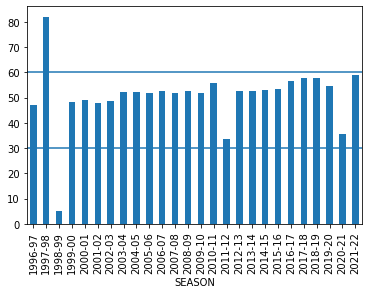

In [27]:
# consider removing outlier in terms of games played 
# since those records are not representative samples of mid-season performance
# 1997-98: 82 games played = whole season but not mid-season, 
  # all-star game was held in Feb (Kobe's debut for youngest all-star player)
  # season lasted from Oct to Apr
# 1998-89: see 1998 NBA lockout
  # < 10 games played = too small of a sample size to gauge mid-season performance
# 2011-12: see 2011 NBA lockout
# 2020-21: see postponed season due to COVID-19
df.groupby('SEASON').GP.mean().plot(kind='bar')
plt.axhline(30)
plt.axhline(60)

In [28]:
# cannot pass this in sklearn pipeline so let's do it on dataset level
# drop any season with games played <= 30 or >= 60 such that we have a large enough sample to gauge mid-season performance
df = df.loc[(df.GP >= 30) & (df.GP <= 60)]

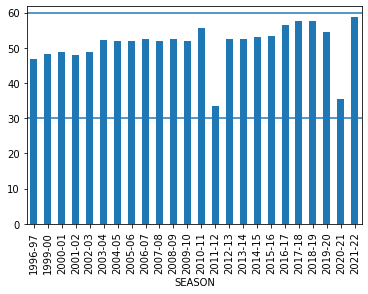

In [29]:
# now fixed
df.groupby('SEASON').GP.mean().plot(kind='bar')
plt.axhline(30)
plt.axhline(60)

In [30]:
# fix datatypes
df.loc[:, 'TEAM_ID'] = df['TEAM_ID'].astype(str)
df.loc[:, 'CFID'] = df['CFID'].astype(str)
df.loc[:, 'PLAYOFF_RANKING'] = df['PLAYOFF_RANKING'].astype('category')
df.loc[:, 'SEASON'] = df['SEASON'].astype('category')


C:\Users\willi\AppData\Local\Temp\ipykernel_39340\2098131275.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'TEAM_ID'] = df['TEAM_ID'].astype(str)
C:\Users\willi\AppData\Local\Temp\ipykernel_39340\2098131275.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'CFID'] = df['CFID'].astype(str)
C:\Users\willi\AppData\Local\Temp\ipykernel_39340\2098131275.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 0 to 771
Data columns (total 96 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   TEAM_ID             712 non-null    object  
 1   TEAM_NAME           712 non-null    object  
 2   GP                  712 non-null    int64   
 3   W                   712 non-null    int64   
 4   L                   712 non-null    int64   
 5   W_PCT               712 non-null    float64 
 6   MIN                 712 non-null    float64 
 7   FGM                 712 non-null    float64 
 8   FGA                 712 non-null    float64 
 9   FG_PCT              712 non-null    float64 
 10  FG3M                712 non-null    float64 
 11  FG3A                712 non-null    float64 
 12  FG3_PCT             712 non-null    float64 
 13  FTM                 712 non-null    float64 
 14  FTA                 712 non-null    float64 
 15  FT_PCT              712 non-null    floa

# Check numeric columns

In [32]:
# no identifier included here
sorted(df.select_dtypes(include=np.number).columns.values)

['AST',
 'AST_PCT',
 'AST_RATIO',
 'AST_TO',
 'BLK',
 'BLKA',
 'DEF_RATING',
 'DREB',
 'DREB_PCT',
 'EFG_PCT',
 'FG3A',
 'FG3M',
 'FG3_PCT',
 'FGA',
 'FGM',
 'FG_PCT',
 'FTA',
 'FTA_RATE',
 'FTM',
 'FT_PCT',
 'GP',
 'L',
 'MIN',
 'NET_RATING',
 'OFF_RATING',
 'OPP_AST',
 'OPP_BLK',
 'OPP_BLKA',
 'OPP_DREB',
 'OPP_EFG_PCT',
 'OPP_FG3A',
 'OPP_FG3M',
 'OPP_FG3_PCT',
 'OPP_FGA',
 'OPP_FGM',
 'OPP_FG_PCT',
 'OPP_FTA',
 'OPP_FTA_RATE',
 'OPP_FTM',
 'OPP_FT_PCT',
 'OPP_OREB',
 'OPP_OREB_PCT',
 'OPP_PF',
 'OPP_PFD',
 'OPP_PTS',
 'OPP_PTS_2ND_CHANCE',
 'OPP_PTS_FB',
 'OPP_PTS_OFF_TOV',
 'OPP_PTS_PAINT',
 'OPP_REB',
 'OPP_STL',
 'OPP_TOV',
 'OPP_TOV_PCT',
 'OREB',
 'OREB_PCT',
 'PACE',
 'PACE_PER40',
 'PCT_AST_2PM',
 'PCT_AST_3PM',
 'PCT_AST_FGM',
 'PCT_FGA_2PT',
 'PCT_FGA_3PT',
 'PCT_PTS_2PT',
 'PCT_PTS_2PT_MR',
 'PCT_PTS_3PT',
 'PCT_PTS_FB',
 'PCT_PTS_FT',
 'PCT_PTS_OFF_TOV',
 'PCT_PTS_PAINT',
 'PCT_UAST_2PM',
 'PCT_UAST_3PM',
 'PCT_UAST_FGM',
 'PF',
 'PFD',
 'PIE',
 'PLUS_MINUS',
 'POSS',
 '

# Train test split with unique identifier = TEAM_ID + SEASON
- hashing unique identifier
- alternative: stratified sampling by season

In [33]:
# unique id = team id + season
df.loc[:, 'UNIQUE_ID'] = df['TEAM_ID'].astype(str) + df['SEASON'].str.replace('-','')

C:\Users\willi\AppData\Local\Temp\ipykernel_39340\3425944132.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'UNIQUE_ID'] = df['TEAM_ID'].astype(str) + df['SEASON'].str.replace('-','')


In [34]:
# instead of train-test_split by random shuffling, hash the unique identifier for train-test split
# slight modification to the technique from Hands On Machine Learning by Aurélien Géron
def split_data_with_id_hash(data, test_ratio, id_column):
  ids = data[id_column]
  threshold = np.quantile(ids.apply(lambda x: crc32(np.int64(x))), test_ratio) # instead of using test_ratio * 2**32 as the threshold, this is more accurate
  in_test_set = ids.apply(lambda x: crc32(np.int64(x)) < threshold) 
  return data.loc[~in_test_set], data.loc[in_test_set]

In [35]:
train_set, test_set = split_data_with_id_hash(df, 0.2, "UNIQUE_ID")

In [36]:
print(f"size of full dataset: {df.shape}")
print(f"size of train dataset: {train_set.shape}")
print(f"size of test dataset: {test_set.shape}")
print(f"train-test ratio: {train_set.shape[0] / df.shape[0]:0.2} / {test_set.shape[0] / df.shape[0]:0.2}")

size of full dataset: (712, 97)
size of train dataset: (569, 97)
size of test dataset: (143, 97)
train-test ratio: 0.8 / 0.2


In [37]:
# save to google drive
train_set.to_pickle('../data/raw/nba_pre_all_star_vs_final4_train_comprehensive.pkl')
test_set.to_pickle('../data/raw/nba_pre_all_star_vs_final4_test_comprehensive.pkl')